# Predicting Energy Efficiency of Buildings

**Background:**

With the increasing emphasis on sustainable and energy-efficient building designs, the construction industry faces the challenge of optimizing energy consumption for heating and cooling systems. Buildings account for a significant portion of total energy consumption, making it crucial to develop accurate predictive models for heating and cooling loads. 

**Objective:**

The goal is to leverage a dataset containing eight architectural attributes (Relative Compactness, Surface Area, Wall Area, Roof Area, Overall Height, Orientation, Glazing Area, Glazing Area Distribution) to predict two key outcomes - Heating Load (y1) and Cooling Load (y2). 

In [1]:
# remove comment below if you wanna install mlflow for the first time
#!pip install mlflow

In [2]:
import warnings

# Suppress specific UserWarnings
warnings.filterwarnings("ignore", category=UserWarning, module='_distutils_hack')

In [3]:
# importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import mlflow.sklearn
import mlflow.pyfunc
from mlflow import MlflowClient

# Understanding data

In [4]:
# loading the data 
energy = pd.read_csv("ENB2012_data.csv")
# Looking at first few rows
energy.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [5]:
# Renaming columns for better readability
energy.columns = ['Relative_Compactness','Surface_Area','Wall_Area','Roof_Area','Overall_Height',
                  'Orientation','Glazing_Area','Glazing_Area_Distribution','Heating_Load','Cooling_Load']
# Final Look at first few rows
energy.head(10)

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
5,0.90,563.5,318.5,122.50,7.0,3,0.0,0,21.46,25.38
6,0.90,563.5,318.5,122.50,7.0,4,0.0,0,20.71,25.16
7,0.90,563.5,318.5,122.50,7.0,5,0.0,0,19.68,29.60
8,0.86,588.0,294.0,147.00,7.0,2,0.0,0,19.50,27.30
9,0.86,588.0,294.0,147.00,7.0,3,0.0,0,19.95,21.97


In [6]:
# display basic info of the data
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative_Compactness       768 non-null    float64
 1   Surface_Area               768 non-null    float64
 2   Wall_Area                  768 non-null    float64
 3   Roof_Area                  768 non-null    float64
 4   Overall_Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing_Area               768 non-null    float64
 7   Glazing_Area_Distribution  768 non-null    int64  
 8   Heating_Load               768 non-null    float64
 9   Cooling_Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


- Looks like the data has no null values.

In [7]:
# Displaying summary statistics of numeric columns
energy.describe()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


**Feature distributions using histograms**

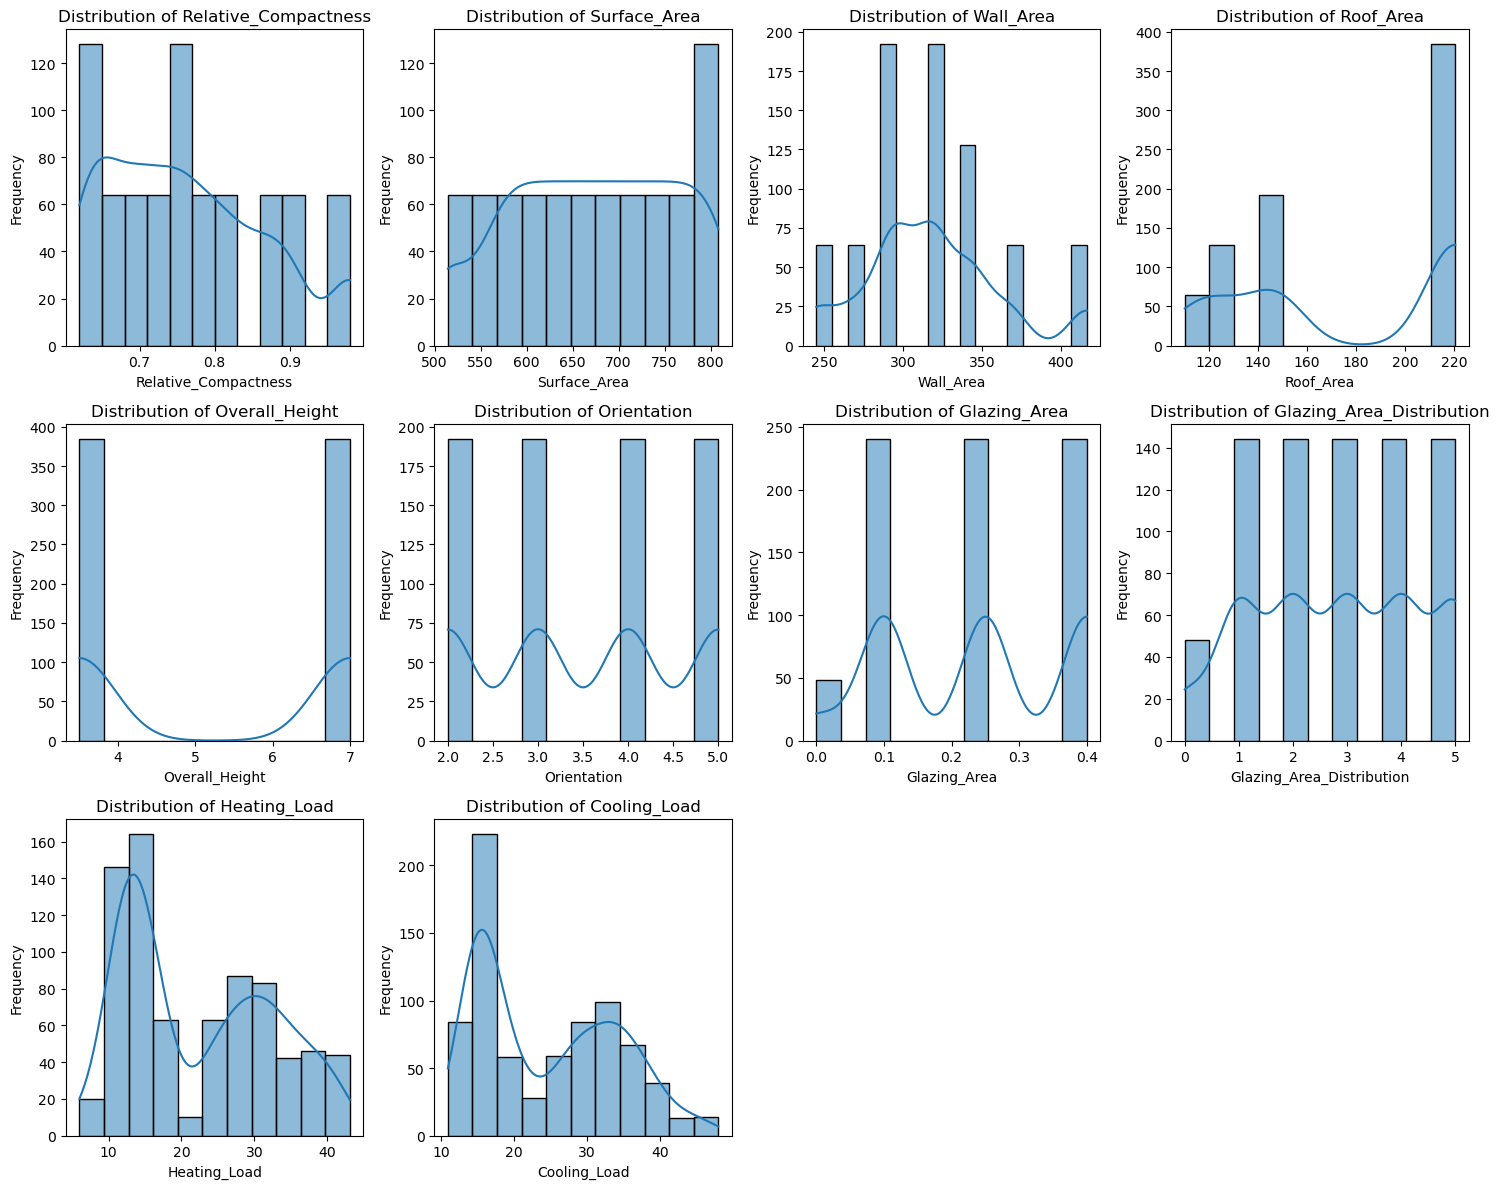

In [8]:
# Visualizing distributions of attributes
plt.figure(figsize=(15, 12))
for i, column in enumerate(energy.columns):
    plt.subplot(3, 4, i + 1)  
    sns.histplot(energy[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Looks like none of the attributes follow gaussian distribution.

Moreover the distribution of target variables looks bimodal, suggesting creation of binary classes.

**Checking Outliers**

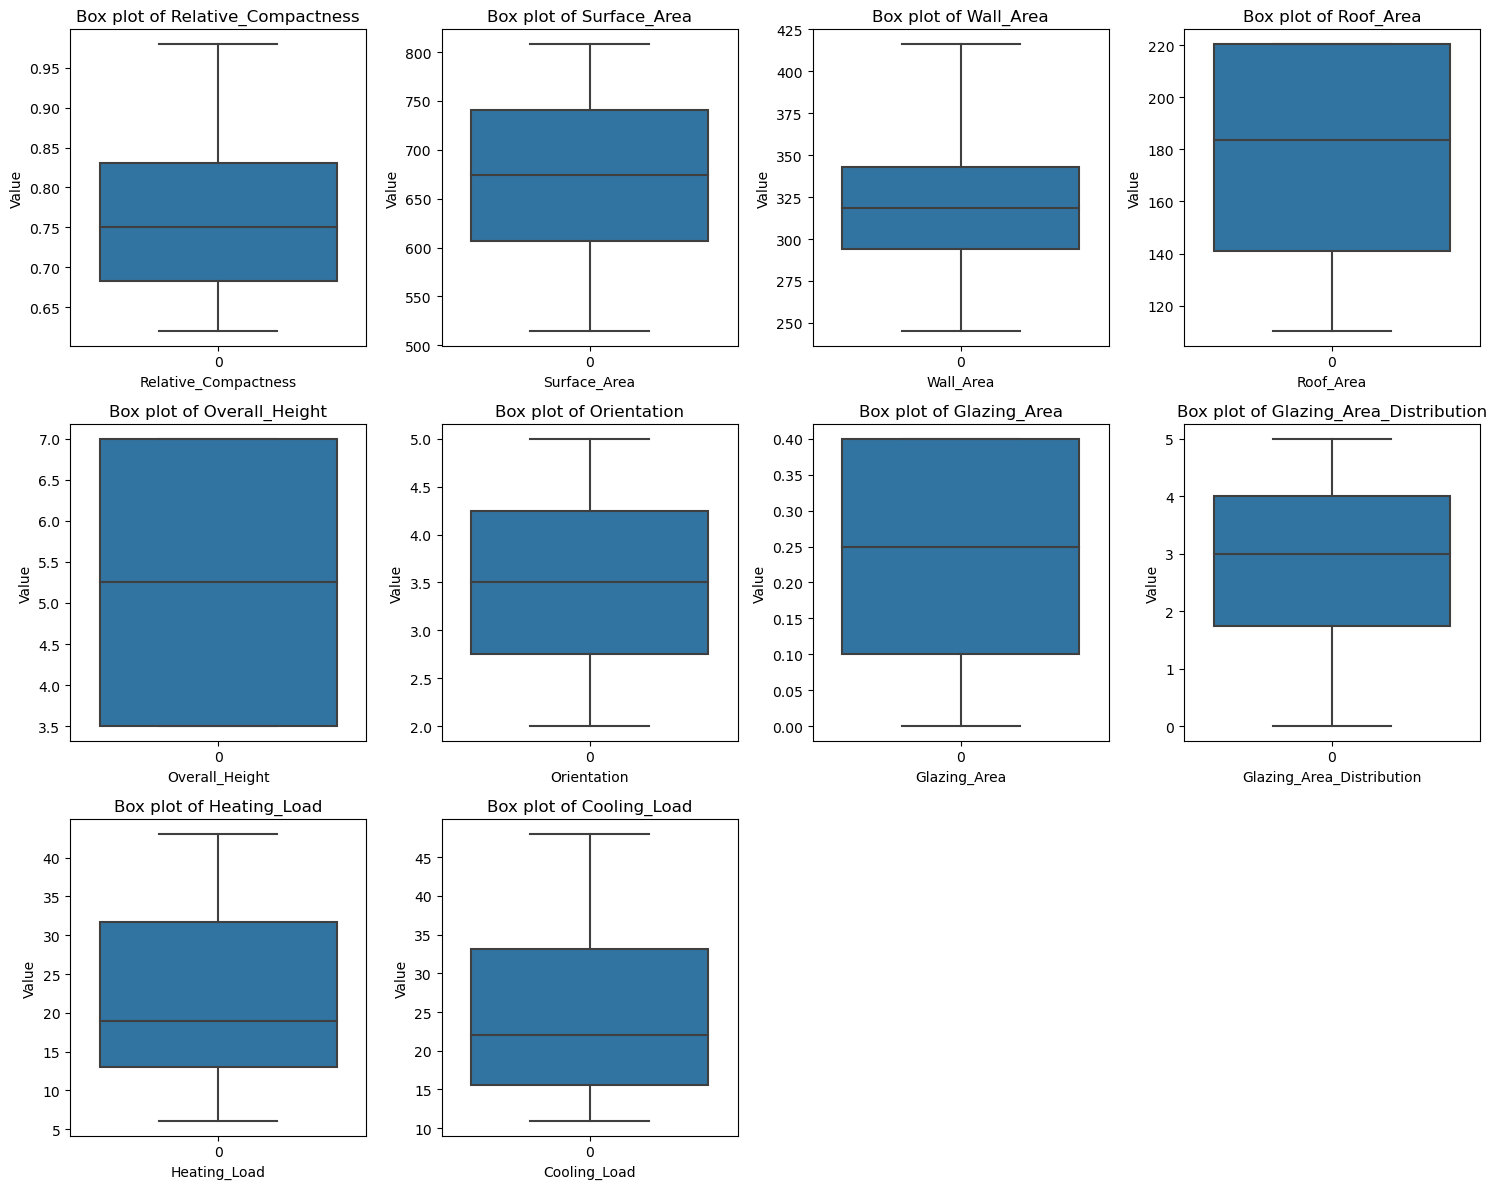

In [9]:
# Creating box plots for each feature to inspect for outliers
plt.figure(figsize=(15, 12))
for i, column in enumerate(energy.columns):
    plt.subplot(3, 4, i + 1)  
    sns.boxplot(energy[column])
    plt.title(f'Box plot of {column}')
    plt.ylabel('Value')
    plt.xlabel(column)
    
plt.tight_layout()
plt.show()

Looks like we don't have outliers in the data.

**Correlations between attributesusing Spearman rank correlation coefficient as the data is non-gaussian.**

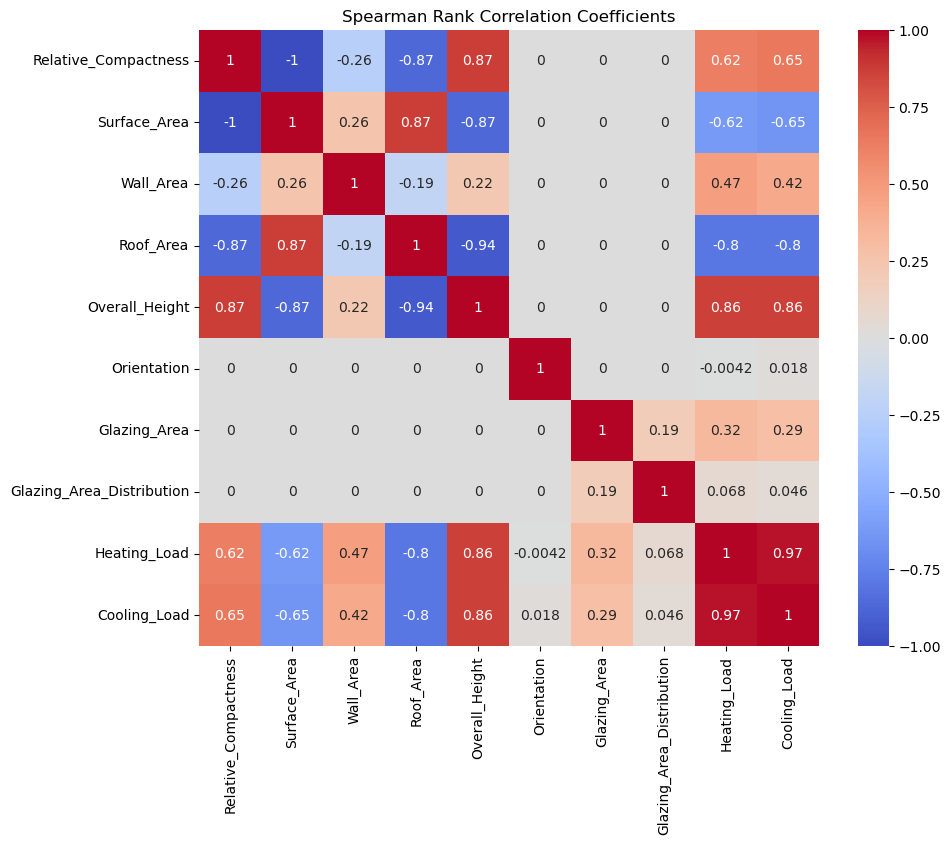

In [10]:
# Calculating the Spearman rank correlation coefficients
spearman_corr = energy.corr(method='spearman')

# Visualizing the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm')
plt.title('Spearman Rank Correlation Coefficients')
plt.show()

- We can say the first five features ('Relative_Compactness','Surface_Area','Wall_Area','Roof_Area,'Overall_Height') are strongly associated with the target variables ('Heating_Load','Cooling_Load').
- The Relative_Compactness and Surface_Area have a perfect negative correlation of -1. 
- Roof_Area and Overall_Height have strong negative correlations with Relative_Compactness and Surface_Area, and a strong positive correlation with each other. 

**Analyzing Feature Relationships with Target variables**

C:\Users\Shanmukhi B\AppData\Local\Temp\ipykernel_12884\1376664965.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Shanmukhi B\AppData\Local\Temp\ipykernel_12884\1376664965.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Shanmukhi B\AppData\Local\Temp\ipykernel_12884\1376664965.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Shanmukhi B\AppData\Local\Temp\ipykernel_12884\1376664965.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Shanmukhi B\AppData\Local\Temp\ipykernel_12884\1376664965.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Shanmukhi B\AppData\Local\Temp\ipykernel_12884\1376664965.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Shanmukhi B\AppData\Local\Temp\ipykernel_12884\1376664965.py:9: UserWarning: The figure layout has changed to tight

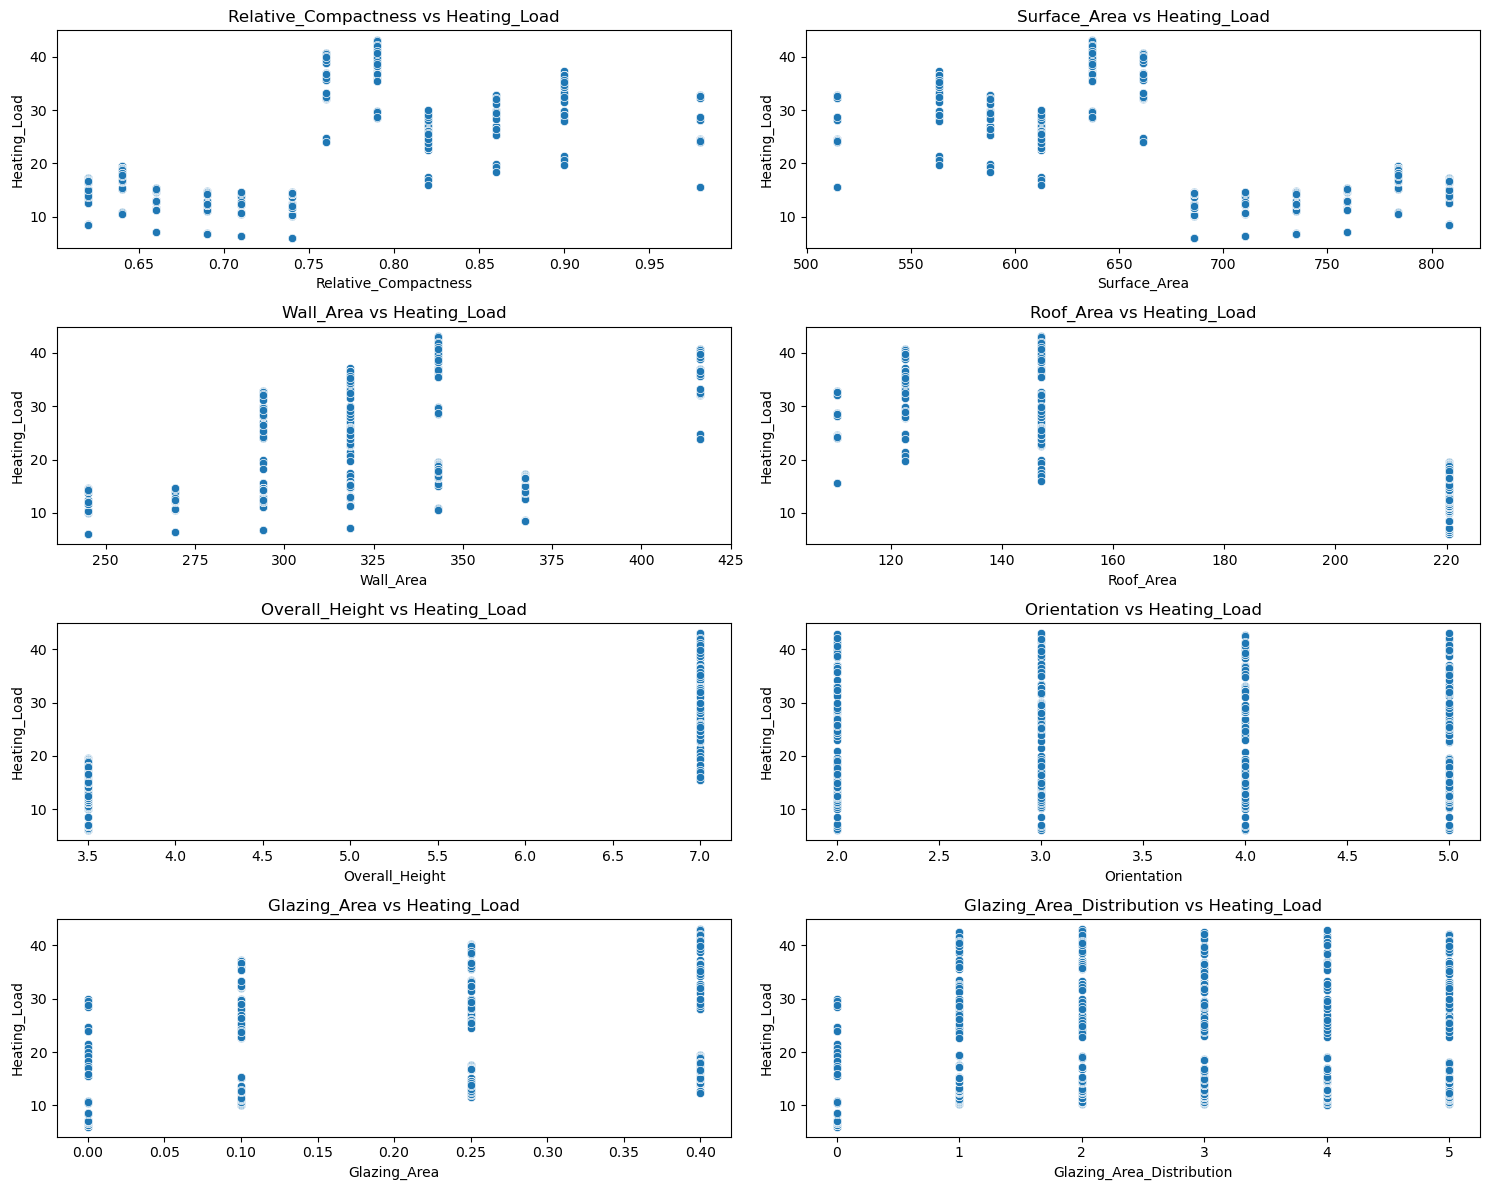

C:\Users\Shanmukhi B\AppData\Local\Temp\ipykernel_12884\1376664965.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Shanmukhi B\AppData\Local\Temp\ipykernel_12884\1376664965.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Shanmukhi B\AppData\Local\Temp\ipykernel_12884\1376664965.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Shanmukhi B\AppData\Local\Temp\ipykernel_12884\1376664965.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Shanmukhi B\AppData\Local\Temp\ipykernel_12884\1376664965.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Shanmukhi B\AppData\Local\Temp\ipykernel_12884\1376664965.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Shanmukhi B\AppData\Local\Temp\ipykernel_12884\1376664965.py:18: UserWarning: The figure layout has changed t

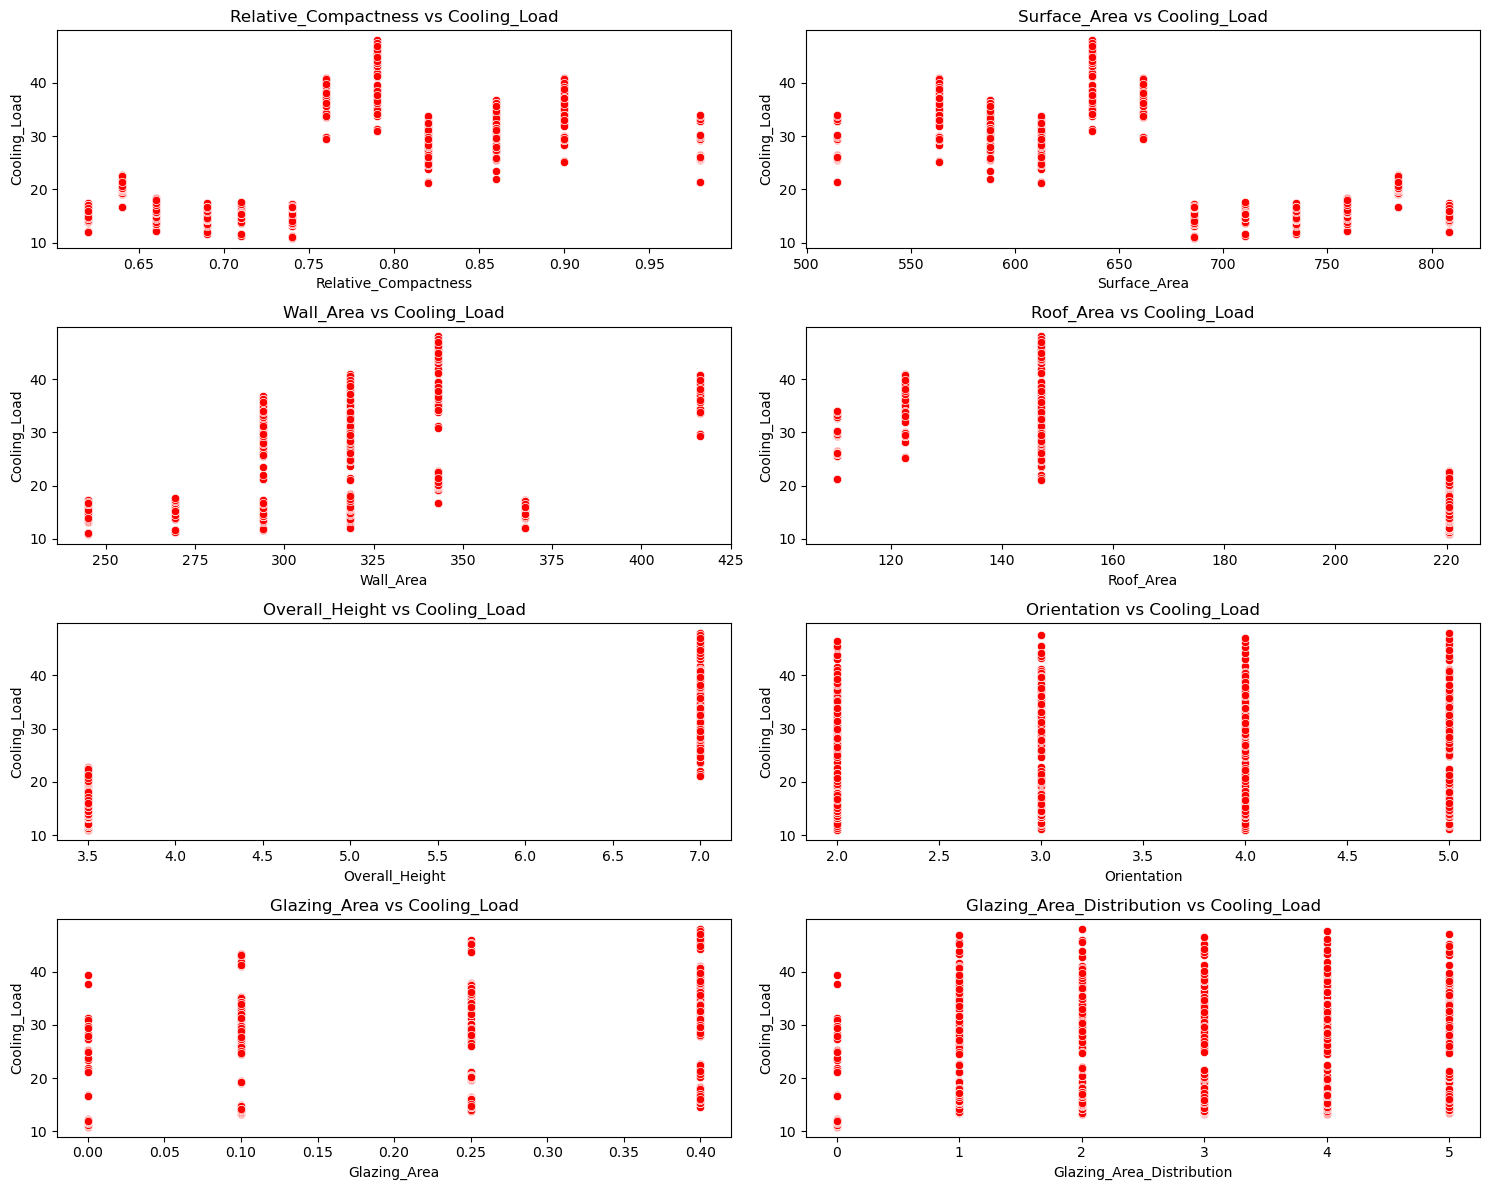

In [11]:
X = ['Relative_Compactness','Surface_Area','Wall_Area','Roof_Area','Overall_Height',
                  'Orientation','Glazing_Area','Glazing_Area_Distribution']
# Features vs Heating loads
plt.figure(figsize=(15, 12))
for i,feature in enumerate(X):
    plt.subplot(4,2,i+1)
    sns.scatterplot(data=energy, x=feature, y='Heating_Load')
    plt.title(f'{feature} vs Heating_Load')
    plt.tight_layout()
plt.show()

# Features vs Cooling load
plt.figure(figsize=(15, 12))
for i,feature in enumerate(X):
    plt.subplot(4,2,i+1)
    sns.scatterplot(data=energy, x=feature, y='Cooling_Load',color='red')
    plt.title(f'{feature} vs Cooling_Load')
    plt.tight_layout()
plt.show()

The scatter plots, which depict input variable against the two output variables, reveal complex and non-obvious relationships. This complexity in the relationships suggests that straightforward methods like linear regression might struggle to accurately map the input variables to the output variables. As a result, these plots provide a compelling rationale for exploring more advanced and sophisticated learning algorithms, such as Random Forests, to better capture the nuances in the data.

# Feature Engineering

- Since Relative_Compactness and Surface_Area are perfectly negatively correlated, we might consider dropping one of them to reduce multicollinearity in the models. Let's say we drop Surface_Area.

In [12]:
energy.drop('Surface_Area', axis=1, inplace=True)

- Given strong correlations between features Roof_Area and Overall_Height, we can consider creating interaction term to capture combined effects.

In [13]:
energy['Roof_Overall_Height'] = energy['Roof_Area'] * energy['Overall_Height']

# Preprocessing

In [14]:
# Splitting the data into features and targets
X = energy.drop(columns=['Heating_Load','Cooling_Load'])
y = energy[['Heating_Load', 'Cooling_Load']] 

In [15]:
# Split data into training and a temporary set (70% training, 30% temporary)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary set into validation and test sets (50% validation, 50% test of the temporary set)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [16]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((537, 8), (115, 8), (116, 8), (537, 2), (115, 2), (116, 2))

In [17]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Model Training and Evaluation with MLflow

In [18]:
mlflow.create_experiment("EE")
mlflow.set_experiment("EE")

<Experiment: artifact_location='file:///d:/Datacamp/Mlflow_reg_Project/mlruns/519072751663547620', creation_time=1703147126427, experiment_id='519072751663547620', last_update_time=1703147126427, lifecycle_stage='active', name='EE', tags={}>

In [19]:
def train_eval_model(model,model_name,X_train,y_train,target,X_val,y_val):
    # Starting run
    mlflow.start_run(run_name=f"{model_name}_{target}")
    # Fitting model
    model.fit(X_train,y_train[target])
    # Prediction on Train data
    pred = model.predict(X_train)
    # Calc. metrics 
    rmse_train = round(mean_squared_error(y_train[target], pred, squared=False),2)
    mae_train = round(mean_absolute_error(y_train[target], pred),2)
    r2_train = round(r2_score(y_train[target], pred),2)
    # Printing results
    print(f"Root Mean Squared Error using Training data: {rmse_train}, Mean Absolute Error using Training data: {mae_train}, R-squared using Training data: {r2_train}")
    # Prediction using Validation data
    val_pred = model.predict(X_val)
    #Calc. metrics
    rmse_val = round(mean_squared_error(y_val[target], val_pred, squared=False),2)
    mae_val = round(mean_absolute_error(y_val[target], val_pred),2)
    r2_val = round(r2_score(y_val[target], val_pred),2)
    # Printing results
    print(f"\nRoot Mean Squared Error using Validation data: {rmse_val}, Mean Absolute Error using Validation data: {mae_val}, R-squared using Validation data: {r2_val}")
    # Logging metrics
    mlflow.log_metrics({'Train RMSE':rmse_train, "Train MAE":mae_train, "Train R2":r2_train, 
                        'Validation RMSE':rmse_val, "Validation MAE":mae_val, "Validation R2":r2_val})
    # Logging model
    mlflow.sklearn.log_model(model, f"{model_name}_{target}")
    run_id =   mlflow.active_run().info.run_uuid
    # Ending run
    mlflow.end_run()

    return run_id

**Predicting Heating Load**

In [20]:
# Using Decision Trees
HL_DT_run_id = train_eval_model(DecisionTreeRegressor(random_state=111),"DecisionTree",X_train_scaled,y_train,
                 'Heating_Load',X_val_scaled,y_val)
print(HL_DT_run_id)

Root Mean Squared Error using Training data: 0.0, Mean Absolute Error using Training data: 0.0, R-squared using Training data: 1.0

Root Mean Squared Error using Validation data: 0.59, Mean Absolute Error using Validation data: 0.42, R-squared using Validation data: 1.0
8bcbc608eb5f42e38491b41366132ad1


In [21]:
# Using Random Forest
HL_RF_run_id = train_eval_model(RandomForestRegressor(random_state=111),"RandomForest",X_train_scaled,y_train,'Heating_Load',
                 X_val_scaled,y_val)
print(HL_RF_run_id)

Root Mean Squared Error using Training data: 0.2, Mean Absolute Error using Training data: 0.13, R-squared using Training data: 1.0

Root Mean Squared Error using Validation data: 0.51, Mean Absolute Error using Validation data: 0.37, R-squared using Validation data: 1.0
8db74f2ddeab479f9f0cfa24bed83d9d


In [22]:
# Using Gradient Boosting
HL_GB_run_id = train_eval_model(GradientBoostingRegressor(random_state=111),"GradientBoosting",X_train_scaled,y_train,'Heating_Load',
                 X_val_scaled,y_val)
print(HL_GB_run_id)

Root Mean Squared Error using Training data: 0.4, Mean Absolute Error using Training data: 0.29, R-squared using Training data: 1.0

Root Mean Squared Error using Validation data: 0.45, Mean Absolute Error using Validation data: 0.34, R-squared using Validation data: 1.0
ef8436a5adaa40c7ae3c613a743567cd


**Predicting Cooling Load**

In [23]:
# Using Decision Trees
CL_DT_run_id = train_eval_model(DecisionTreeRegressor(random_state=111),"DecisionTree",X_train_scaled,y_train,
                 'Cooling_Load',X_val_scaled,y_val)
print(CL_DT_run_id)

Root Mean Squared Error using Training data: 0.0, Mean Absolute Error using Training data: 0.0, R-squared using Training data: 1.0

Root Mean Squared Error using Validation data: 1.69, Mean Absolute Error using Validation data: 0.96, R-squared using Validation data: 0.97
29892071196e45269e0b0f3bbbba2e3d


In [24]:
# Using Random Forest
CL_RF_run_id = train_eval_model(RandomForestRegressor(random_state=111),"RandomForest",X_train_scaled,y_train,
                 'Cooling_Load',X_val_scaled,y_val)
print(CL_RF_run_id)

Root Mean Squared Error using Training data: 0.67, Mean Absolute Error using Training data: 0.39, R-squared using Training data: 1.0

Root Mean Squared Error using Validation data: 1.62, Mean Absolute Error using Validation data: 1.04, R-squared using Validation data: 0.97
15f1f0784a5940a6bbdf2a925d62b3ba


In [25]:
# Using Gradient Boosting
CL_GB_run_id = train_eval_model(GradientBoostingRegressor(random_state=111),"GradientBoosting",X_train_scaled,y_train,
                 'Cooling_Load',X_val_scaled,y_val)
print(CL_GB_run_id)

Root Mean Squared Error using Training data: 1.26, Mean Absolute Error using Training data: 0.84, R-squared using Training data: 0.98

Root Mean Squared Error using Validation data: 1.51, Mean Absolute Error using Validation data: 1.01, R-squared using Validation data: 0.97
9daa654273a84ce6ac587d9d8a0e0404


**Searching runs**

In [26]:
mlflow.search_runs()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Validation R2,metrics.Validation MAE,metrics.Train RMSE,metrics.Train MAE,metrics.Train R2,metrics.Validation RMSE,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.log-model.history
0,9daa654273a84ce6ac587d9d8a0e0404,519072751663547620,FINISHED,file:///d:/Datacamp/Mlflow_reg_Project/mlruns/...,2023-12-21 08:26:03.471000+00:00,2023-12-21 08:26:09.406000+00:00,0.97,1.01,1.26,0.84,0.98,1.51,Shanmukhi B,GradientBoosting_Cooling_Load,C:\Users\Shanmukhi B\anaconda3\Lib\site-packag...,LOCAL,"[{""run_id"": ""9daa654273a84ce6ac587d9d8a0e0404""..."
1,15f1f0784a5940a6bbdf2a925d62b3ba,519072751663547620,FINISHED,file:///d:/Datacamp/Mlflow_reg_Project/mlruns/...,2023-12-21 08:25:56.820000+00:00,2023-12-21 08:26:03.427000+00:00,0.97,1.04,0.67,0.39,1.00,1.62,Shanmukhi B,RandomForest_Cooling_Load,C:\Users\Shanmukhi B\anaconda3\Lib\site-packag...,LOCAL,"[{""run_id"": ""15f1f0784a5940a6bbdf2a925d62b3ba""..."
2,29892071196e45269e0b0f3bbbba2e3d,519072751663547620,FINISHED,file:///d:/Datacamp/Mlflow_reg_Project/mlruns/...,2023-12-21 08:25:50.828000+00:00,2023-12-21 08:25:56.775000+00:00,0.97,0.96,0.00,0.00,1.00,1.69,Shanmukhi B,DecisionTree_Cooling_Load,C:\Users\Shanmukhi B\anaconda3\Lib\site-packag...,LOCAL,"[{""run_id"": ""29892071196e45269e0b0f3bbbba2e3d""..."
3,ef8436a5adaa40c7ae3c613a743567cd,519072751663547620,FINISHED,file:///d:/Datacamp/Mlflow_reg_Project/mlruns/...,2023-12-21 08:25:44.428000+00:00,2023-12-21 08:25:50.792000+00:00,1.00,0.34,0.40,0.29,1.00,0.45,Shanmukhi B,GradientBoosting_Heating_Load,C:\Users\Shanmukhi B\anaconda3\Lib\site-packag...,LOCAL,"[{""run_id"": ""ef8436a5adaa40c7ae3c613a743567cd""..."
4,8db74f2ddeab479f9f0cfa24bed83d9d,519072751663547620,FINISHED,file:///d:/Datacamp/Mlflow_reg_Project/mlruns/...,2023-12-21 08:25:37.494000+00:00,2023-12-21 08:25:44.380000+00:00,1.00,0.37,0.20,0.13,1.00,0.51,Shanmukhi B,RandomForest_Heating_Load,C:\Users\Shanmukhi B\anaconda3\Lib\site-packag...,LOCAL,"[{""run_id"": ""8db74f2ddeab479f9f0cfa24bed83d9d""..."
5,8bcbc608eb5f42e38491b41366132ad1,519072751663547620,FINISHED,file:///d:/Datacamp/Mlflow_reg_Project/mlruns/...,2023-12-21 08:25:27.038000+00:00,2023-12-21 08:25:37.448000+00:00,1.00,0.42,0.00,0.00,1.00,0.59,Shanmukhi B,DecisionTree_Heating_Load,C:\Users\Shanmukhi B\anaconda3\Lib\site-packag...,LOCAL,"[{""run_id"": ""8bcbc608eb5f42e38491b41366132ad1""..."


In [27]:
HL_runs = mlflow.search_runs(experiment_names=["EE"],
filter_string="tags.mlflow.runName LIKE '%Heating_Load'")

In [28]:
# Select only metrics and run name
HL_data = HL_runs[['tags.mlflow.runName'] + [col for col in HL_runs.columns if col.startswith('metrics.')]]

# Print the selected data
HL_data = pd.DataFrame(HL_data)
HL_data

,tags.mlflow.runName,metrics.Validation R2,metrics.Validation MAE,metrics.Train RMSE,metrics.Train MAE,metrics.Train R2,metrics.Validation RMSE
0,GradientBoosting_Heating_Load,1.0,0.34,0.4,0.29,1.0,0.45
1,RandomForest_Heating_Load,1.0,0.37,0.2,0.13,1.0,0.51
2,DecisionTree_Heating_Load,1.0,0.42,0.0,0.00,1.0,0.59


In [29]:
CL_runs = mlflow.search_runs(experiment_names=["EE"],
filter_string="tags.mlflow.runName LIKE '%Cooling_Load'")

In [30]:
# Select only metrics and run name
CL_data = CL_runs[['tags.mlflow.runName'] + [col for col in CL_runs.columns if col.startswith('metrics.')]]

# Print the selected data
CL_data = pd.DataFrame(CL_data)
CL_data

,tags.mlflow.runName,metrics.Validation R2,metrics.Validation MAE,metrics.Train RMSE,metrics.Train MAE,metrics.Train R2,metrics.Validation RMSE
0,GradientBoosting_Cooling_Load,0.97,1.01,1.26,0.84,0.98,1.51
1,RandomForest_Cooling_Load,0.97,1.04,0.67,0.39,1.00,1.62
2,DecisionTree_Cooling_Load,0.97,0.96,0.00,0.00,1.00,1.69


Based on the validation metrics, the Gradient Boosting model seems to be the better choice for predicting the heating load and cooling load. It shows a balance between training performance and the ability to generalize, as evidenced by its validation metrics.

# Hyperparameter Tuning with MLflow

In [31]:
# Gradient Boosting
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'subsample': [0.8, 0.9, 1.0]
}

In [32]:
# Performing random Search
random_search = RandomizedSearchCV(GradientBoostingRegressor(), gb_params, cv=5, scoring='neg_mean_squared_error')
random_search.fit(X_train_scaled, y_train['Heating_Load'])
HL_best_model = random_search.best_estimator_
random_search.fit(X_train_scaled, y_train['Cooling_Load'])
CL_best_model = random_search.best_estimator_

In [33]:
# Predictions using Best Model - Heating Load
HL_TunedGB_run_id = train_eval_model(HL_best_model,"Tuned-GradientBoosting",X_train_scaled,y_train,
                 'Heating_Load',X_val_scaled,y_val)
print(HL_TunedGB_run_id)

Root Mean Squared Error using Training data: 0.27, Mean Absolute Error using Training data: 0.19, R-squared using Training data: 1.0

Root Mean Squared Error using Validation data: 0.45, Mean Absolute Error using Validation data: 0.34, R-squared using Validation data: 1.0
eb0d550e75d94af0bf002269ce7f1aa5


In [34]:
# Predictions using Best Model - Cooling Load
CL_TunedGB_run_id = train_eval_model(CL_best_model,"Tuned-GradientBoosting",X_train_scaled,y_train,
                 'Cooling_Load',X_val_scaled,y_val)
print(CL_TunedGB_run_id)

Root Mean Squared Error using Training data: 0.39, Mean Absolute Error using Training data: 0.27, R-squared using Training data: 1.0

Root Mean Squared Error using Validation data: 0.97, Mean Absolute Error using Validation data: 0.6, R-squared using Validation data: 0.99
cff72529e8af48b88c96553e7b35a582


For both Heating Load and Cooling Load the model shows significant improvement post-tuning, but the perfect R-squared scores raise concerns about overfitting. Let's predict using test data for both loads and see!

# Feature Importance

Lets look at the feature importance in Tuned Gradient Boosting Regressor model for both loads.

In [35]:
def plot_feature_importance(model, feature_names):
   
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10,6))
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.show()

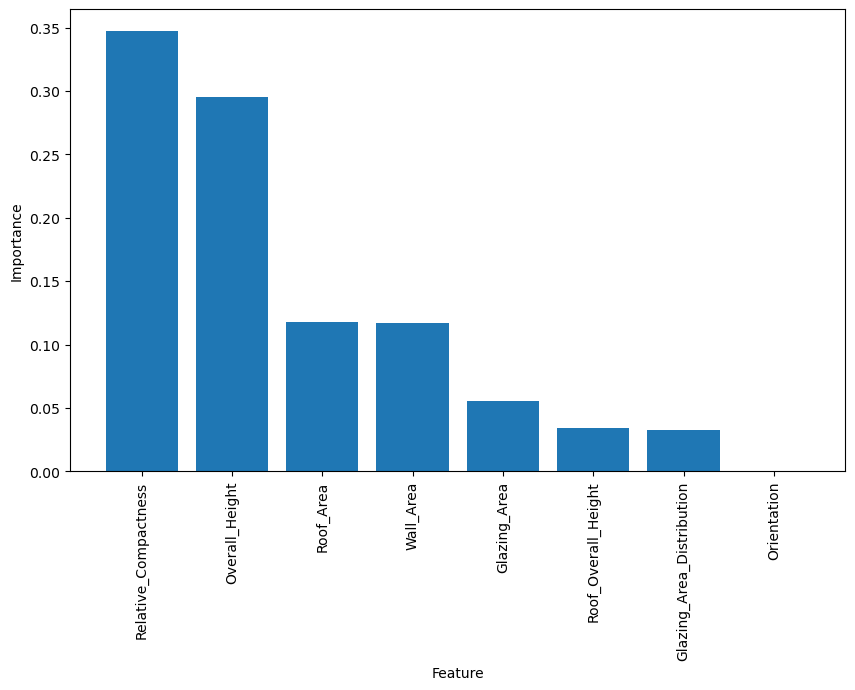

In [36]:
# Heating Load feature importance
plot_feature_importance(HL_best_model,X_train.columns)

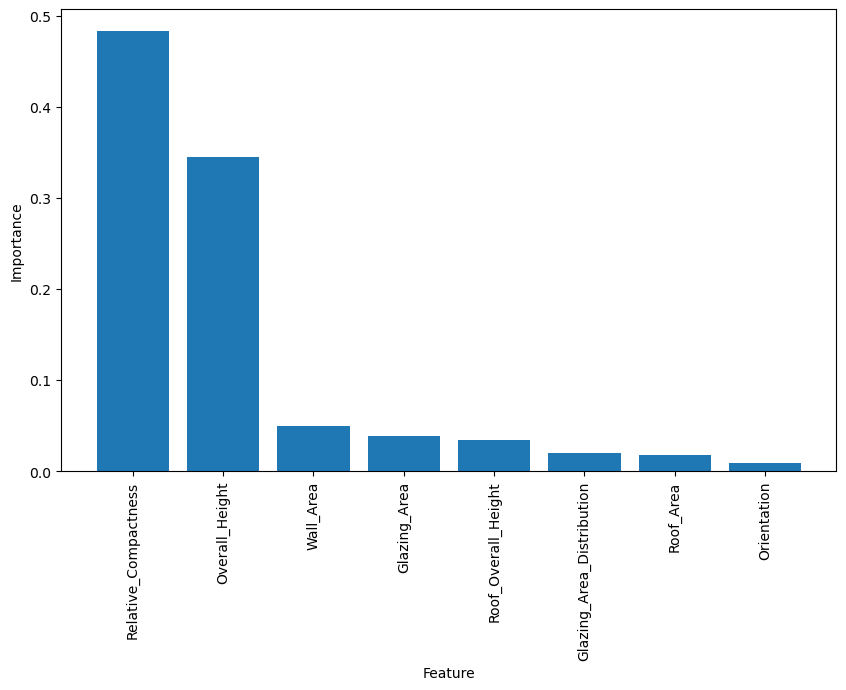

In [37]:
# Cooling Load feature importance
plot_feature_importance(CL_best_model,X_train.columns)

# Predictions

Lets load the logged model from MLflow for both loads, make predictions and evaluate using test data

**Predicting Heating Load**

In [38]:
# Loading a logged model - Heating Load
HL_loaded_model = mlflow.pyfunc.load_model(f"runs:/{HL_TunedGB_run_id}/Tuned-GradientBoosting_Heating_Load")

In [39]:
# predicting using test data
predictions = HL_loaded_model.predict(X_test_scaled)

In [40]:
# Calc. metrics
rmse = mean_squared_error(y_test['Heating_Load'], predictions, squared=False)
mae = mean_absolute_error(y_test['Heating_Load'], predictions)
r2 = r2_score(y_test['Heating_Load'], predictions)

print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")
print(f"Test R-squared: {r2}")

Test RMSE: 0.42727956814643225
Test MAE: 0.31492245927727897
Test R-squared: 0.998136163017729


**Predicting Cooling Load**

In [41]:
# Loading a logged model - Cooling Load
CL_loaded_model = mlflow.pyfunc.load_model(f"runs:/{CL_TunedGB_run_id}/Tuned-GradientBoosting_Cooling_Load")

In [42]:
# predicting using test data
predictions = CL_loaded_model.predict(X_test_scaled)

In [43]:
#Calc. metrics
rmse = mean_squared_error(y_test['Cooling_Load'], predictions, squared=False)
mae = mean_absolute_error(y_test['Cooling_Load'], predictions)
r2 = r2_score(y_test['Cooling_Load'], predictions)

print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")
print(f"Test R-squared: {r2}")

Test RMSE: 0.7856358306963901
Test MAE: 0.549229815992316
Test R-squared: 0.9930718319850127


### Overall Observations:

**Strong Model Performance:** Both models exhibit strong performance on the test data. The high R-squared values combined with relatively low RMSE and MAE indicate that the models are making accurate predictions with a high degree of reliability.

**Generalization:** The fact that these metrics are consistent with the validation metrics suggests that the models are generalizing well and are not overfitting.

**Comparison:** While both models perform well, the metrics indicate that the model for heating load is slightly more accurate than the one for cooling load. This could be due to differences in the nature of the data or how well the features capture the underlying patterns for each load type.

# Register Models for production inference

In [44]:
# creating client instance
client = MlflowClient()
client.create_registered_model(name="HeatingLoad")
client.create_registered_model(name="CoolingLoad")

<RegisteredModel: aliases={}, creation_timestamp=1703147221154, description=None, last_updated_timestamp=1703147221154, latest_versions=[], name='CoolingLoad', tags={}>

In [45]:
# Registering Models from Tracking Server
mlflow.register_model(f"runs:/{HL_TunedGB_run_id}/Tuned-GradientBoosting_Heating_Load","HeatingLoad") # Heating Load Model
mlflow.register_model(f"runs:/{CL_TunedGB_run_id}/Tuned-GradientBoosting_Cooling_Load","CoolingLoad") # Cooling Load Model

Registered model 'HeatingLoad' already exists. Creating a new version of this model...
Created version '1' of model 'HeatingLoad'.
Registered model 'CoolingLoad' already exists. Creating a new version of this model...
Created version '1' of model 'CoolingLoad'.


<ModelVersion: aliases=[], creation_timestamp=1703147221260, current_stage='None', description=None, last_updated_timestamp=1703147221260, name='CoolingLoad', run_id='cff72529e8af48b88c96553e7b35a582', run_link=None, source='file:///d:/Datacamp/Mlflow_reg_Project/mlruns/519072751663547620/cff72529e8af48b88c96553e7b35a582/artifacts/Tuned-GradientBoosting_Cooling_Load', status='READY', status_message=None, tags={}, user_id=None, version=1>

**Transition Models to 'Production' Stage**

In [46]:
# Transition the heating load model to production
client.transition_model_version_stage(
    name="HeatingLoad",
    version=1,  # replace with your model version
    stage="Production"
)

C:\Users\Shanmukhi B\AppData\Local\Temp\ipykernel_12884\3004677537.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.2/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1703147221203, current_stage='Production', description=None, last_updated_timestamp=1703147221320, name='HeatingLoad', run_id='eb0d550e75d94af0bf002269ce7f1aa5', run_link=None, source='file:///d:/Datacamp/Mlflow_reg_Project/mlruns/519072751663547620/eb0d550e75d94af0bf002269ce7f1aa5/artifacts/Tuned-GradientBoosting_Heating_Load', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [47]:
# Transition the cooling load model to production
client.transition_model_version_stage(
    name="CoolingLoad",
    version=1,  # replace with your model version
    stage="Production"
)

C:\Users\Shanmukhi B\AppData\Local\Temp\ipykernel_12884\603547916.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.2/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1703147221260, current_stage='Production', description=None, last_updated_timestamp=1703147221401, name='CoolingLoad', run_id='cff72529e8af48b88c96553e7b35a582', run_link=None, source='file:///d:/Datacamp/Mlflow_reg_Project/mlruns/519072751663547620/cff72529e8af48b88c96553e7b35a582/artifacts/Tuned-GradientBoosting_Cooling_Load', status='READY', status_message=None, tags={}, user_id=None, version=1>